### RoBERT for News Classification

Here we have used RoBERTa-base Sequence Classifier (Transformer) to classify given news dataset into 4 classes:

○ World (0)
○ Sports (1)
○ Business (2)
○ Sci/Tech (3)

We cleaned the dataset first:

-> Converted the whole dataset to lower case.

-> Removed punctuation marks.

-> Replaced numbers and words containing numbers as a sunstring with "NUM" tokens.


We finetuned this transformer model for 15 epochs to learn the pattern to the best using AdamW optimizer using a LR of 0.00001. We kept a moderate batch size of 16 for frequenet gradient update

The best accuracy score we could achieve on test set is 88.09 % approx.

In [1]:
import nltk
import re
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

##### Load the train data

In [4]:
train_val_set = pd.read_csv('./NLP3/train.csv')

In [5]:
train_val_set.head()

,index,text,label
0,0,Zimbabwe annual inflation drops to 209 percent...,0
1,1,"More than 1,000 dead in Haiti (09/23/04)-- A m...",0
2,2,Seven die in Japan #39;suicide pact #39; Japa...,0
3,3,Security No. 1 for Afghan head President Hamid...,0
4,4,Palestinians say they hope Bush accepts dealin...,0


In [6]:
print(f'Train_Val set contains total {len(train_val_set)} rows with {train_val_set.label.unique()} unique classes(labels)')

Train_Val set contains total 2000 rows with [0 1 2 3] unique classes(labels)


In [7]:
def remove_symbols(text):
    pattern = r'[^\w\s]'  
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

In [8]:
train_val_set['text'] = train_val_set['text'].apply(lambda x: x.lower()) 
train_val_set['text'] = train_val_set['text'].apply(remove_symbols) 
train_val_set['text'] = train_val_set['text'].apply(lambda x: x.replace('\\', ' ')) 
train_val_set['text'] = train_val_set['text'].replace(r'\b[a-zA-Z]*\d+[a-zA-Z]*\b', 'NUM', regex=True)

In [9]:
train_val_set.head(5)

,index,text,label
0,0,zimbabwe annual inflation drops to NUM percent...,0
1,1,more than NUM dead in haiti NUM a mass grave i...,0
2,2,seven die in japan NUM pact NUM japanese poli...,0
3,3,security no NUM for afghan head president hami...,0
4,4,palestinians say they hope bush accepts dealin...,0


##### Split the train set into Train and Validation Set

In [10]:
train_set, val_set = train_test_split(train_val_set, test_size=0.1, random_state=42)

print(f'Length of the train set: {len(train_set)}\nLength of the validation set: {len(val_set)}')

Length of the train set: 1800
Length of the validation set: 200


In [11]:
y_train_raw = list(train_set['label']) 
y_val_raw = list(val_set['label'])

In [12]:
len(y_train_raw), len(y_val_raw)

(1800, 200)

In [13]:
train_set_text = list(train_set['text'])
val_set_text = list(val_set['text'])

##### Load the Test Data

In [14]:
test_set = pd.read_csv('./NLP3/test.csv')

In [15]:
print(f'Test set contains total {len(test_set)} rows with {test_set.label.unique()} unique classes(labels)')

Test set contains total 500 rows with [0 1 2 3] unique classes(labels)


In [16]:
y_test_raw = list(test_set['label'])
len(y_test_raw)

500

In [17]:
test_set['text'] = test_set['text'].apply(lambda x: x.lower()) 
test_set['text'] = test_set['text'].apply(remove_symbols) 
test_set['text'] = test_set['text'].apply(lambda x: x.replace('\\', ' ')) 
test_set['text'] = test_set['text'].replace(r'\b[a-zA-Z]*\d+[a-zA-Z]*\b', 'NUM', regex=True)

In [18]:
test_set.head()

,index,text,label
0,0,detainees seen as minimal threat washington m...,0
1,1,japans army works out plan to cope with north ...,0
2,2,un council arrives in nairobi un security coun...,0
3,3,apec ministers urge new effort on trade talks ...,0
4,4,at least five dead in russia mine blast reuter...,0


In [19]:
test_set_text = list(test_set['text'])

### Models

#### Tokenizer

In [20]:
from transformers import RobertaTokenizer

In [21]:
tokenizer = RobertaTokenizer.from_pretrained("FacebookAI/roberta-base")

In [22]:
tokenized_numeric_converted_train_sentences = tokenizer(train_set_text, padding = True, return_tensors = 'pt')
tokenized_numeric_converted_test_sentences = tokenizer(test_set_text, padding = 'max_length', max_length = 201, return_tensors = 'pt')
tokenized_numeric_converted_val_sentences = tokenizer(val_set_text, padding = 'max_length', max_length = 201, return_tensors = 'pt')

#### Data Preparation

In [23]:
X_train  = tokenized_numeric_converted_train_sentences
X_val = tokenized_numeric_converted_val_sentences
X_test = tokenized_numeric_converted_test_sentences

print(f"Shape of the X_train inputs_ids {X_train['input_ids'].shape} And attention mask: {X_train['attention_mask'].shape}")
print(f"Shape of the X_val inputs_ids {X_val['input_ids'].shape} And attention mask: {X_val['attention_mask'].shape}")
print(f"Shape of the X_test inputs_ids {X_test['input_ids'].shape} And attention mask: {X_test['attention_mask'].shape}")

Shape of the X_train inputs_ids torch.Size([1800, 201]) And attention mask: torch.Size([1800, 201])
Shape of the X_val inputs_ids torch.Size([200, 201]) And attention mask: torch.Size([200, 201])
Shape of the X_test inputs_ids torch.Size([500, 201]) And attention mask: torch.Size([500, 201])


In [24]:
# Define a custom dataset class

class NewsDataset(Dataset):

    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        input_id = torch.tensor(self.input_ids[idx])
        attention_mask = torch.tensor(self.attention_masks[idx])
        label = torch.tensor(self.labels[idx])
        return {"input_ids": input_id, "attention_mask": attention_mask, "labels": label}

In [25]:
batch_size = 16

In [26]:
# Create TensorDatasets and DataLoaders for train set

train_dataset = NewsDataset(X_train['input_ids'], X_train['attention_mask'] , y_train_raw)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

In [27]:
# Create TensorDatasets and DataLoaders for Val set.

val_dataset = NewsDataset(X_val['input_ids'], X_val['attention_mask'] , y_val_raw)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False)

In [28]:
# Create TensorDatasets and DataLoaders for Val set.

test_dataset = NewsDataset(X_test['input_ids'], X_test['attention_mask'] , y_test_raw)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

### Sequence Classifier Model

In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [30]:
# since we have only 4 classes, we initialize the model with 4 nodes in the last classification layer.

num_of_classes = 4

In [31]:
# Pass the num_of_classes to the model, so that it can get the number of classes

from transformers import RobertaForSequenceClassification
robertaModel = RobertaForSequenceClassification.from_pretrained("FacebookAI/roberta-base", num_labels = num_of_classes).to('cuda')

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
# Hyperparameters

num_epochs = 15
lr = 0.00001

In [33]:
def accuracy_fn(y_true, y_pred):
    
    correct = torch.eq(y_true, y_pred).sum().item()
    accuracy = ( correct/len(y_pred) ) * 100
    
    return accuracy

In [34]:
# Loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(robertaModel.parameters(), lr = lr)

In [35]:
performance_metrics = []
best_val_accuracy = 0

for epoch in tqdm(range(num_epochs)):
    
    robertaModel.train()
    train_loss = 0
    
    for batch_idx, batch in enumerate(train_dataloader):
        
        inputs = {k: v.to(device) for k, v in batch.items()}
        output_y_train_pred = robertaModel(**inputs)
                
        # calculate batch accumulative loss
        loss = output_y_train_pred.loss
        train_loss += loss.item()
        
        # print(loss.item())
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
    with torch.inference_mode():
        
        robertaModel.eval()
        val_loss, val_accuracy = 0,0
        
        for batch_val in val_dataloader:
            
            inputs_eval = {k: v.to(device) for k, v in batch_val.items()}
            output_y_val_pred = robertaModel(**inputs_eval)
            
            loss = output_y_val_pred.loss
            val_loss += loss.item()
            
            y_val = batch_val['labels'].to(device)
            
            # print(f'y_val True: {y_val}\ny_val_predicted: {output_y_val_pred.logits.argmax(dim = 1)}\n')
            
            val_accuracy += accuracy_fn(y_val, output_y_val_pred.logits.argmax(dim=1))
        
        # Calculate avg. loss & accuracy
        
        train_loss = train_loss / len(train_dataloader)
        val_loss = val_loss / len(val_dataloader)
        val_accuracy = val_accuracy / len(val_dataloader)
        
        print(f"Epoch:{epoch+1} | Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f} | Val accuracy: {val_accuracy:.5f}")
        performance_metrics.append(val_accuracy)

        if val_accuracy > best_val_accuracy:
            torch.save(robertaModel, './roberta_finetuned_custom_num_4.pt')
            print('Model Checkpoint Saved\n')
            best_val_accuracy = val_accuracy

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch:1 | Train loss: 0.7608 | Val loss: 0.3198 | Val accuracy: 90.86538
Model Checkpoint Saved

Epoch:2 | Train loss: 0.3322 | Val loss: 0.3679 | Val accuracy: 88.94231
Epoch:3 | Train loss: 0.2349 | Val loss: 0.3348 | Val accuracy: 90.38462
Epoch:4 | Train loss: 0.1784 | Val loss: 0.3556 | Val accuracy: 89.90385
Epoch:5 | Train loss: 0.1259 | Val loss: 0.4064 | Val accuracy: 88.46154
Epoch:6 | Train loss: 0.1062 | Val loss: 0.3508 | Val accuracy: 91.34615
Model Checkpoint Saved

Epoch:7 | Train loss: 0.0623 | Val loss: 0.5741 | Val accuracy: 88.46154
Epoch:8 | Train loss: 0.0959 | Val loss: 0.3706 | Val accuracy: 91.34615
Epoch:9 | Train loss: 0.0455 | Val loss: 0.4470 | Val accuracy: 88.94231
Epoch:10 | Train loss: 0.0329 | Val loss: 0.4483 | Val accuracy: 90.86538
Epoch:11 | Train loss: 0.0125 | Val loss: 0.4801 | Val accuracy: 90.86538
Epoch:12 | Train loss: 0.0083 | Val loss: 0.5212 | Val accuracy: 90.38462
Epoch:13 | Train loss: 0.0141 | Val loss: 0.5436 | Val accuracy: 90.38462

### Evaluation On Test Set

In [36]:
# Load the latest Best checkpoint saved above.

y_predicted_list_roberta, y_test_true_roberta = [],[]

robertaModel_best_chkpt = torch.load('./roberta_finetuned_custom_num_4.pt').to(device)

with torch.inference_mode():
    robertaModel_best_chkpt.eval()
    test_loss, test_accuracy = 0,0

    for batch_test in tqdm(test_dataloader):

        inputs_test = {k: v.to(device) for k, v in batch_test.items()}
        output_y_test_pred = robertaModel_best_chkpt(**inputs_test)

        loss = output_y_test_pred.loss
        test_loss += loss
        
        y_test = batch_test['labels'].to(device)
        test_accuracy += accuracy_fn(y_test, output_y_test_pred.logits.argmax(dim=1))
        
        y_predicted_list_roberta.append(output_y_test_pred.logits.argmax(dim=1))
        y_test_true_roberta.append(y_test)

    # Calculate avg. loss & accuracy
    
    test_loss = test_loss/len(test_dataloader)
    test_accuracy = test_accuracy/len(test_dataloader)

    print(f"Test loss: {test_loss:.4f} | Test accuracy: {test_accuracy:.2f}")

  0%|          | 0/32 [00:00<?, ?it/s]

Test loss: 0.4235 | Test accuracy: 88.09


#### Test Accuracy of the BERT Model

In [45]:
print(f'Test Accuracy for the RoBERTa-base Sequence Classifier model is: {test_accuracy:.2f} %')

Test Accuracy for the RoBERTa-base Sequence Classifier model is: 88.09 %


In [38]:
# Convert the list of tensors to a single list of elements

y_predicted_list_roberta = [item for tensor in y_predicted_list_roberta for item in tensor.tolist()]
y_test_true_roberta = [item for tensor in y_test_true_roberta for item in tensor.tolist()]

#### F-1 Score

In [39]:
f1 = f1_score(np.array(y_test_true_roberta), np.array(y_predicted_list_roberta), average='weighted')
print(f'F1 Score for the model is: {f1:.4f}')

F1 Score for the model is: 0.8839


#### Confusion Matrix

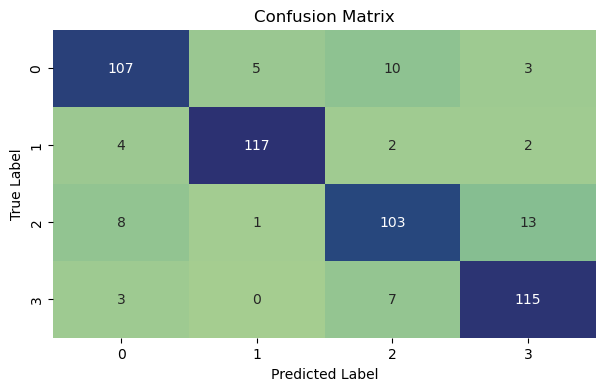

In [40]:
# Calculate confusion matrix
cm = confusion_matrix(y_test_true_roberta, y_predicted_list_roberta)

# Plot confusion matrix
plt.figure(figsize=(7, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='crest', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### Write Predictions to CSV

In [41]:
RoBERTModifiedTestSet = test_set.copy()
RoBERTModifiedTestSet.head()

,index,text,label
0,0,detainees seen as minimal threat washington m...,0
1,1,japans army works out plan to cope with north ...,0
2,2,un council arrives in nairobi un security coun...,0
3,3,apec ministers urge new effort on trade talks ...,0
4,4,at least five dead in russia mine blast reuter...,0


In [42]:
RoBERTModifiedTestSet['preds'] = y_predicted_list_roberta

In [43]:
RoBERTModifiedTestSet.to_csv('bert_test.csv', index=False)

In [44]:
# Test if the data has been written to the csv

df = pd.read_csv('bert_test.csv')
df.head()

,index,text,label,preds
0,0,detainees seen as minimal threat washington m...,0,0
1,1,japans army works out plan to cope with north ...,0,0
2,2,un council arrives in nairobi un security coun...,0,0
3,3,apec ministers urge new effort on trade talks ...,0,2
4,4,at least five dead in russia mine blast reuter...,0,0
